### Anly 580 Final Report

# How Can Topic Modeling Retrieve Information from Academic Research Papers, and Assign the Right Labels of Topic?

### Student group members and which student is responsible for what parts?
+ Data cleaning and preprocessing: Shiqi Ning (sn661)

+ Exploratory data analysis: Wen Li (wl565)

+ LDA Model: Xi Yang (xy140)

+ LSI Model: Jianing Sun (js4770)

### Motivation

+ Our research question is 'How can topic modeling retrieve information from academic research papers, and assign the right labels of topic?'

+ With the rapid accumulation of various scientific articles which are available online, machine learning methods such as topic modeling have been receiving much attention in those professional fields because of their interpretability. 

+ By analyzing “How Can Topic Modeling Retrieve Information from Academic Research Papers, and Assign the Right Labels of Topic?”, we can better identify the topic classification that are trending research topics in different academic realm in an efficient way.

### Relevant background research

Most of the work on the scientific research analysis implements with citations [1]. This method includes discovering the citation frequency, patterns and graphs to establish graphs between words and researchers. 

Another method to the academic research analysis depends on topic models. Topic modeling methods discover the hidden similarity between documents throughout the collection and annotate the documents content. The most popular topic model is Latent Dirichlet Allocation (LDA).	

Michael Paul and Roxana Girju implemented various novel topic models including LDA to classify research papers based on topic and language. They successfully gave various insightful statistics and correlations within and across three research fields: Linguistics, Computational Linguistics, and Education and showed a number of trends in each field along with relationships between topics, temporal correlations and topic influences across fields, as well as language trends. [2] 

Akira Murakami, Paul Thompson, Susan Hunston implemented Latent Dirichlet allocation (LDA) to automatically identifies “topics” in a given corpus. [3] They built model with 40, 50, 60, …, 100 topics and found 60 topics was the right level of granularity. In addition, they successfully built dynamic topic models that account for chronological change of keywords with topics.

### Data (collection) 
+ Dataset is collected using Springer Nature API, an API that allows developers to access 13 million freely available online content published by Springer.
+ Mathematics is chosen as the topic for query.
+ 10000 abstracts and titles from academic articles, papers, and book chapters are obtained from query.
+ Raw query dataset is JSON format.
+ Following codes are used to query the abstracts and titles

In [ ]:
# Import neede packages
import requests
import pandas as pd
import tqdm

# Define apikey and base 
apikey = 'df78856d424d8eba5d4b18ef9d70d0d8'
url_base = 'http://api.springernature.com/meta/v2/json'

# Set number of query and number of records each query
n_query = 100
n_eve_query = 100

# Initialize the dataframe and counter
df_raw = pd.DataFrame(columns=['doi', 'title', 'abstract'])
counter = 0

# Run specified number of iterations
for i in tqdm.tqdm(range(n_query)):
    # Set post url
    url_post = {'q': {'subject:Mathematics'},
                'p': n_eve_query,
                's': i*n_query + 1,
                'api_key':apikey
                }

    # Get response and convert to json
    response=requests.get(url_base, params = url_post)
    jsontxt = response.json()

    # Get records
    records = jsontxt['records']

    # Run through every record during the query
    for rec in records:
        # Get title, doi, and abstract
        title = rec['title']
        doi = rec['doi']
        abstract = rec['abstract']

        # Store the record into the data frame
        df_raw.loc[counter, 'title'] = title
        df_raw.loc[counter, 'doi'] = doi
        df_raw.loc[counter, 'abstract'] = abstract

        # Update counter
        counter += 1

# Save the dataframe to csv file
with open('df_abstract.csv','w', encoding="utf-8-sig", newline='') as output:
    df_raw.to_csv(output, sep=',',index = True, encoding='utf-8-sig')

# Check the shape of the raw data frame
print(df_raw.shape)

### Methods
**Latent Dirichlet Allocation (LDA)**
+ Created dictionary and corpus with Gensim.
+ Trained LDA model with LdaMulticore and traditional LDA.
+ Analyzed topics found by LDA model and generated new stop words for better results.
+ Generated weighted topics.

**Latent Semantic Indexing (LSI)**
+ Generate a document-term matrix of shape having TF-IDF scores using sklearn.
+ Reduce the dimensions of the matrix to k (no. of desired topics) dimensions, using singular-value decomposition (SVD).
+ Analyze topics found by LSI and do more data-preprocessing (add stop words, lemmatization, tokenization) 

**Important packages and tools**
+ Natural language related: regex, nltk, genism and sklearn.
+ Plotting related: matplotlib, bokeh, wordcloud, and seaborn.
+ Data related: requests, pandas, numpy, 


In [2]:
# Import libraries
import pandas as pd
import numpy as np

import nltk
#nltk.download('punkt') # wordpunct_tokenize
#nltk.download('averaged_perceptron_tagger') # tagged words

from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize

# Preprocessing data
from nltk.corpus import stopwords

# Count word type
from nltk.probability import ConditionalFreqDist
from nltk.probability import FreqDist

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
import re
import nltk

from gensim import corpora
from gensim.models import LdaModel, LdaMulticore
from gensim import models

import matplotlib.colors as mcolors

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from collections import Counter

from matplotlib.patches import Rectangle

### Procedure
**Data Cleaning**
+ Query results with empty abstracts are cleaned.
+ Abstracts written in languages other than English are cleaned out (9766 abstracts are left).
+ Content written in latex, latex math equations, and latex symbols (contents between single or double dollar signs) are cleaned out.
+ Single character, number, and special signs are cleaned out using regular expression.
+ Following codes are used to preprocess the data.

In [3]:
with open('df_abstract.csv', 'r', encoding="utf-8-sig") as abstract_data:
        df_raw = pd.read_csv(abstract_data , sep=',', index_col = False, header = 0, encoding="utf-8-sig")
    
    
df_raw = df_raw.loc[: , ['title', 'abstract']]

df_raw.dropna(axis = 0, inplace = True)

df_short = df_raw[:10000]

**Data Processing**
+ Words in the titles are then tokenized and lemmatized.
+ Stop words in English, as well as customized stop words for mathematics are cleaned out.
+ build bigram
+ tf-idf weights are calculated for selecting words in corpus

In [1]:
##########################################
# Step 0: Import packages and stopwords
##########################################
import gensim
from pprint import pprint
from gensim.models import LdaModel, LdaMulticore
import gensim.downloader as api
from gensim.utils import simple_preprocess, lemmatize
from nltk.corpus import stopwords
import re
import logging

from nltk.stem import WordNetLemmatizer
import pandas as pd
lemmatizer = WordNetLemmatizer() 
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.root.setLevel(level=logging.INFO)
stop_words = stopwords.words('english')
stop_words = stop_words + ['equation','solution','function','problem','space','method','model','operator']


In [2]:
##########################################
# Step 1: Import dataset
##########################################
dataset = pd.read_csv("df_abstract.csv")
data = [d.split() for d in dataset.title]

In [6]:
########################################################
# Step 2: Prepare Data (Remove stopwords and lemmatize)
########################################################

# Build the bigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)
print(bigram_mod[data[2]])

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
import pattern

data_processed = []
for i, doc in enumerate(bigram_mod[data[:1000]]):
    #print(i)
    #print(doc)
    doc_out = []
    for wd in doc:
        if wd not in stop_words:  # remove stopwords
            #print(wd)
            lemmatized_word = lemmatize(wd, allowed_tags=re.compile('(NN|JJ|RB)'))  # lemmatize
            #print(lemmatized_word)
            ## Or use nltk #
            #lemmatized_word = lemmatizer.lemmatize(wd)
            if lemmatized_word:
                doc_out = doc_out + [lemmatized_word[0].split(b'/')[0].decode('utf-8')]                     
        else:
            continue
    # After lemmatized, remove stopwords again
    line_out = []
    for wrd in doc_out:
        lemma_wrd = lemmatizer.lemmatize(wrd)
        if lemma_wrd not in stop_words:
            line_out.append(lemma_wrd)
    data_processed.append(line_out)

# Print a small sample    
print(data_processed[0][:5]) 
#> ['regulator']

2019-12-08 21:45:20,140 : INFO : collecting all words and their counts
2019-12-08 21:45:20,147 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-12-08 21:45:20,454 : INFO : collected 75264 word types from a corpus of 102059 words (unigram + bigrams) and 10000 sentences
2019-12-08 21:45:20,455 : INFO : using 75264 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
2019-12-08 21:45:20,455 : INFO : source_vocab length 75264
2019-12-08 21:45:21,859 : INFO : Phraser built with 116 phrasegrams


['The', 'Experimental', 'Approach']
['regulator']


In [7]:
####################################################################################
# Step 3: Create the Inputs of LSI model: Dictionary and Corpus(with TF-IDF Weights)
####################################################################################
from gensim import corpora
dct = corpora.Dictionary(data_processed)
corpus = [dct.doc2bow(line) for line in data_processed]

# Show the Word Weights in Corpus
for doc in corpus:
    print([[dct[id], freq] for id, freq in doc])

# Create the TF-IDF model
from gensim import models
import numpy as np

tfidf = models.TfidfModel(corpus, smartirs='ntc')
corpus_tfidf = tfidf[corpus]

# Show the TF-IDF weights
for doc in corpus_tfidf:
    print([[dct[id], np.around(freq, decimals=2)] for id, freq in doc])

2019-12-08 21:45:43,880 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-12-08 21:45:43,896 : INFO : built Dictionary(2016 unique tokens: ['regulator', 'design', 'imitation', 'invention', 'organic']...) from 1000 documents (total 5256 corpus positions)
2019-12-08 21:45:44,047 : INFO : collecting document frequencies
2019-12-08 21:45:44,047 : INFO : PROGRESS: processing document #0
2019-12-08 21:45:44,064 : INFO : calculating IDF weights for 1000 documents and 2016 features (5178 matrix non-zeros)


[['regulator', 1]]
[['design', 1], ['imitation', 1], ['invention', 1], ['organic', 1], ['reference', 1], ['shape', 1]]
[['approach', 1], ['experimental', 1]]
[['imaging', 1], ['medium', 1], ['random', 1]]
[['aerodynamic', 1], ['high', 1], ['number', 1], ['reynold', 1], ['separated', 1]]
[]
[['analyze', 1], ['artwork', 1], ['geometry', 2], ['music', 1], ['musical', 1], ['order', 1], ['piece', 1], ['use', 1]]
[['fire', 1], ['forest', 1]]
[['atla', 1], ['atlas', 1], ['first', 1], ['gauss', 1], ['geomagnetic', 1], ['geomagnetism', 1], ['history', 1]]
[['electric', 1], ['network', 1], ['random_walk', 1]]
[['boundary', 1], ['oblique', 1], ['stochastic', 1]]
[['optimal', 1], ['performance', 1]]
[['direction', 1], ['dynamic', 1], ['future', 1], ['research', 1]]
[['complementary', 1], ['datum', 1], ['field', 1], ['global', 1], ['goce', 1], ['gravity', 1], ['statistic', 1]]
[['electrical', 1], ['impedance', 1], ['tomography', 1]]
[['ill', 1], ['regularization', 1]]
[['earth', 1], ['inversion', 1

[['geodetic', 0.72], ['boundary_value', 0.69]]
[['architecture', 0.75], ['dimension', 0.66]]
[['filter', 0.54], ['information', 0.43], ['neighborhood', 0.54], ['recovery', 0.48]]
[['datum', 0.29], ['regularization', 0.34], ['satellite', 0.33], ['continuation', 0.48], ['downward', 0.48], ['multiparameter', 0.48]]
[['design', 0.36], ['strategy', 0.35], ['insight', 0.48], ['key', 0.48], ['valuable', 0.54]]
[['approach', 0.28], ['porous_medium', 0.43], ['efficient', 0.38], ['flow', 0.3], ['multus', 0.6], ['transport', 0.38]]
[['theory', 0.48], ['turbulence', 0.88]]
[['mass', 0.63], ['oceanic', 0.63], ['self', 0.45]]
[['case', 0.71], ['study', 0.71]]
[['system', 0.28], ['controller', 0.64], ['lti', 0.64], ['stability', 0.33]]
[['cartography', 1.0]]
[['experimental', 0.63], ['research', 0.59], ['result', 0.5]]
[['geomagnetic', 0.41], ['datum', 0.33], ['field', 0.31], ['source', 0.43], ['modern', 0.45], ['investigation', 0.49]]
[['tomography', 0.44], ['mathematical', 0.42], ['coherence', 0.61

[['degree', 0.34], ['self', 0.7], ['pm', 0.44], ['lens', 0.44]]
[['game', 0.32], ['stability', 0.25], ['profile', 0.41], ['asymmetric', 0.49], ['evolutionary', 0.44], ['polymorphic', 0.49]]
[['physical', 0.47], ['point', 0.33], ['topological', 0.37], ['entropy', 0.47], ['behaviour', 0.56]]
[['regularization', 0.26], ['value', 0.24], ['approximation', 0.2], ['parameter', 0.25], ['decomposition', 0.23], ['estimation', 0.28], ['singular', 0.21], ['rank', 0.29], ['convergence', 0.24], ['predictive', 0.31], ['risk', 0.31], ['tikhonov', 0.36], ['unbiased', 0.36]]
[['generalized', 0.27], ['spherical', 0.39], ['series', 0.3], ['partial', 0.41], ['fourier', 0.32], ['sum', 0.34], ['multiple', 0.35], ['localization', 0.43]]
[['approximation', 0.38], ['polynomial', 0.37], ['exponential', 0.49], ['kantorovich', 0.69]]
[['high', 0.33], ['level', 0.39], ['initial', 0.39], ['energy', 0.35], ['nonlinearity', 0.37], ['logarithmic', 0.42], ['laplace', 0.39]]
[['completion', 0.37], ['matrix', 0.3], ['sing

**Latent Semantic Indexing (LSI)**
+ Train LSI Model and print out the results.

In [8]:
####################################################################################
# Step 4: Train the LSI model
####################################################################################
from gensim.models import LsiModel

# Build the LSI Model
lsi_model = LsiModel(corpus=corpus_tfidf, id2word=dct, num_topics=6, decay=0.5)

# View Topics
pprint(lsi_model.print_topics())

"""
[(0,
  '0.578*"method" + 0.358*"multiscale" + 0.321*"problem" + 0.227*"model" + '
  '0.225*"geomathematic" + 0.163*"reduction" + 0.153*"regularization" + '
  '0.153*"ill" + 0.133*"datum" + 0.119*"finite"'),
 (1,
  '0.726*"geometry" + 0.188*"music" + 0.188*"order" + 0.188*"use" + '
  '0.188*"musical" + 0.188*"piece" + 0.188*"analyze" + 0.188*"artwork" + '
  '0.176*"inverse" + 0.154*"problem"'),
 (2,
  '0.378*"field" + 0.339*"gravity" + -0.307*"problem" + 0.289*"datum" + '
  '0.285*"global" + 0.214*"geometry" + 0.182*"earth" + 0.153*"geomagnetic" + '
  '0.147*"goce" + 0.138*"satellite"'),
 (3,
  '0.467*"model" + -0.329*"problem" + 0.239*"multiscale" + 0.213*"simulation" '
  '+ -0.181*"gravity" + -0.169*"inverse" + -0.164*"field" + -0.151*"global" + '
  '0.128*"soil" + 0.128*"land"'),
 (4,
  '0.389*"problem" + -0.364*"method" + 0.303*"inverse" + 0.276*"model" + '
  '0.201*"simulation" + 0.153*"geoscience" + 0.133*"soil" + 0.133*"effect" + '
  '0.133*"land" + 0.133*"scale"'),
 (5,
  '0.477*"multiscale" + 0.258*"geomagnetic" + 0.245*"function" + '
  '-0.217*"method" + -0.209*"numerical" + -0.202*"datum" + 0.174*"analysis" + '
  '0.131*"field" + 0.130*"scalar" + -0.128*"earth"'),
 (6,
  '-0.386*"function" + -0.305*"analysis" + 0.285*"multiscale" + 0.226*"field" '
  '+ -0.223*"vector" + -0.213*"spherical" + -0.189*"signal" + '
  '-0.189*"spectral" + -0.189*"estimation" + -0.189*"slepian"')]
"""

2019-12-08 22:11:28,673 : INFO : using serial LSI version on this node
2019-12-08 22:11:28,681 : INFO : updating model with new documents
2019-12-08 22:11:28,738 : INFO : preparing a new chunk of documents
2019-12-08 22:11:28,750 : INFO : using 100 extra samples and 2 power iterations
2019-12-08 22:11:28,750 : INFO : 1st phase: constructing (2016, 106) action matrix
2019-12-08 22:11:28,763 : INFO : orthonormalizing (2016, 106) action matrix
2019-12-08 22:11:31,219 : INFO : 2nd phase: running dense svd on (106, 1000) matrix
2019-12-08 22:11:31,412 : INFO : computing the final decomposition
2019-12-08 22:11:31,412 : INFO : keeping 6 factors (discarding 89.041% of energy spectrum)
2019-12-08 22:11:31,422 : INFO : processed documents up to #1000
2019-12-08 22:11:31,422 : INFO : topic #0(2.656): 0.341*"system" + 0.236*"group" + 0.170*"polynomial" + 0.165*"stability" + 0.159*"fractional" + 0.144*"control" + 0.140*"nonlinear" + 0.137*"analysis" + 0.135*"linear" + 0.133*"time"
2019-12-08 22:11

[(0,
  '0.341*"system" + 0.236*"group" + 0.170*"polynomial" + 0.165*"stability" + '
  '0.159*"fractional" + 0.144*"control" + 0.140*"nonlinear" + 0.137*"analysis" '
  '+ 0.135*"linear" + 0.133*"time"'),
 (1,
  '-0.637*"group" + 0.341*"system" + 0.226*"control" + -0.196*"finite" + '
  '-0.150*"algebra" + 0.126*"fractional" + -0.125*"automorphism" + '
  '-0.115*"subgroup" + -0.110*"abelian" + -0.100*"compact"'),
 (2,
  '-0.476*"system" + -0.320*"control" + -0.301*"group" + 0.249*"theorem" + '
  '0.189*"approximation" + 0.186*"fractional" + 0.179*"inequality" + '
  '0.147*"integral" + 0.128*"application" + 0.122*"surface"'),
 (3,
  '-0.401*"fractional" + -0.334*"inequality" + -0.231*"integral" + '
  '0.209*"analysis" + -0.191*"generalized" + 0.186*"stability" + '
  '0.155*"stochastic" + -0.134*"system" + -0.132*"group" + 0.126*"field"'),
 (4,
  '-0.437*"theorem" + 0.285*"fractional" + -0.275*"approximation" + '
  '-0.268*"polynomial" + -0.192*"system" + -0.151*"ideal" + '
  '-0.149*"appli

'\n[(0,\n  \'0.578*"method" + 0.358*"multiscale" + 0.321*"problem" + 0.227*"model" + \'\n  \'0.225*"geomathematic" + 0.163*"reduction" + 0.153*"regularization" + \'\n  \'0.153*"ill" + 0.133*"datum" + 0.119*"finite"\'),\n (1,\n  \'0.726*"geometry" + 0.188*"music" + 0.188*"order" + 0.188*"use" + \'\n  \'0.188*"musical" + 0.188*"piece" + 0.188*"analyze" + 0.188*"artwork" + \'\n  \'0.176*"inverse" + 0.154*"problem"\'),\n (2,\n  \'0.378*"field" + 0.339*"gravity" + -0.307*"problem" + 0.289*"datum" + \'\n  \'0.285*"global" + 0.214*"geometry" + 0.182*"earth" + 0.153*"geomagnetic" + \'\n  \'0.147*"goce" + 0.138*"satellite"\'),\n (3,\n  \'0.467*"model" + -0.329*"problem" + 0.239*"multiscale" + 0.213*"simulation" \'\n  \'+ -0.181*"gravity" + -0.169*"inverse" + -0.164*"field" + -0.151*"global" + \'\n  \'0.128*"soil" + 0.128*"land"\'),\n (4,\n  \'0.389*"problem" + -0.364*"method" + 0.303*"inverse" + 0.276*"model" + \'\n  \'0.201*"simulation" + 0.153*"geoscience" + 0.133*"soil" + 0.133*"effect" + \'

### Results from LSI Model

In [9]:
####################################################################################
# Step 5: Visualization for LSI Model
####################################################################################

# Dominant Topic: This way, you will know which document belongs predominantly to which topic.
def format_topics_sentences_lsi(LsiModel=None, corpus=corpus, texts=data):
    """
    Extract all the information needed such as most predominant topic assigned to document and percentage of contribution
    LsiModel= model to be used
    corpus = corpus to be used
    texts = original text to be classify (for topic assignment)
    """
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(LsiModel[corpus_tfidf]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = LsiModel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences_lsi(lsi_model, corpus=corpus_tfidf, texts=data_processed)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Texts']
df_dominant_topic.head(10)
df_dominant_topic.to_csv("df_dominant_topic.csv")

### LSI Visulization
**Author: Wen Li**
+ pie chart of count of topics
+ word clound for different topics

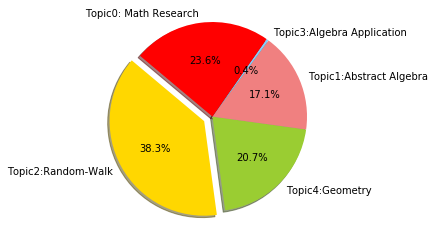

In [12]:
import pandas as pd
df = pd.read_csv('df_dominant_topic.csv')

#df1 = df[df['Sales'] >= s]
df.Dominant_Topic.value_counts()

import matplotlib.pyplot as plt

# Data to plot
labels = 'Topic2:Random-Walk', 'Topic4:Geometry', 'Topic1:Abstract Algebra', 'Topic3:Algebra Application', 'Topic0: Math Research'
sizes = [381, 206, 170, 4, 235]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue',  'red']
explode = (0.1, 0, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

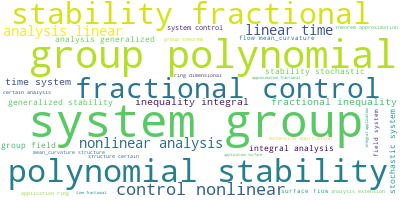

In [13]:
import pandas as pd
df = pd.read_csv('df_dominant_topic.csv')

df1 = df[df['Dominant_Topic'] == 0]
df2 = df[df['Dominant_Topic'] == 1]
df3 = df[df['Dominant_Topic'] == 2]
df4 = df[df['Dominant_Topic'] == 3]
df5 = df[df['Dominant_Topic'] == 4]
df6 = df[df['Dominant_Topic'] == 5]

from wordcloud import WordCloud

def plot_wordcloud(df, dfx):
    list_ = []
    for i in range(len(dfx)):
        list_.append(df['Keywords'][i])
    text = ' '.join(list_)

    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
    wordcloud.generate(text)
# Visualize the word cloud
    return wordcloud.to_image()
plot_wordcloud(df, df1)

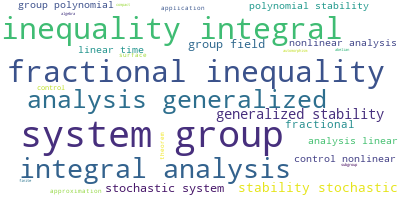

In [14]:
plot_wordcloud(df, df2)


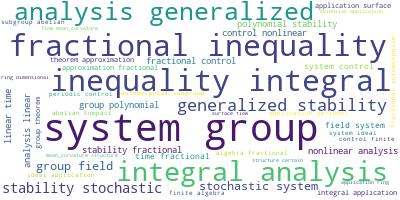

In [15]:
plot_wordcloud(df, df3)


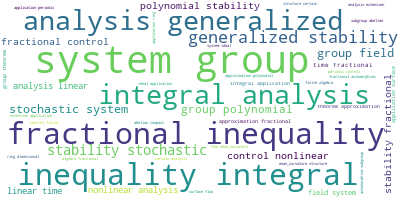

In [16]:
plot_wordcloud(df, df4)


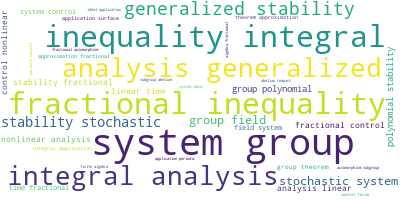

In [17]:
plot_wordcloud(df, df6)

### Analysis
+ Latent Dirichlet Allocation (LDA) model is useful to perform topic modelling task on abstracts of academic articles and papers.
+ By tuning LDA model and ameliorate data preprocessing workflow, different math-related keywords are gathered into different topics: linear algorithm (Topic 0), geometry (Topic 1), algebra with finite method (Topic 2), and etc.
+ Latent Semantics Indexing (LSI) helps to figure out the hidden concepts or topics behind the words. The documents are gathered into 5 different topics, 2 of which are combined manually later on the poster.


### References
[1] R. Rubin. Foundations of Library and Information Science. 2nd ed. New York: Neal-Schuman, 2004.

[2] Michael Paul and Roxana Girju. Topic Modeling of Research Fields: An Interdisciplinary Perspective, 2009 In https://www.aclweb.org/anthology/R09-1061/

[3] Akira Murakami. Getting to know your corpus: applying Topic Modelling to corpus of research articles. University of Cambridge, 2016
